In [69]:
from datetime import datetime
from datetime import timezone
import polars as pl
import os

#acropolis_directory = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/quickflow/acropolis/"
acropolis_directory = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/Old"

In [70]:
#df = pl.scan_parquet(os.path.join(acropolis_directory, "pivot_measurements.parquet"))
df = pl.scan_parquet(os.path.join(acropolis_directory, "old_db_renamed_measurements.parquet"))

df = df.sort("creation_timestamp")
df.head(3).collect()

creation_timestamp,system_name,variant,gmp343_raw,gmp343_compensated,gmp343_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,gmp343_temperature,cal_bottle_id,wxt532_speed_avg,wxt532_speed_max,wxt532_speed_min,wxt532_direction_avg,wxt532_direction_max,wxt532_direction_min,wxt532_last_update_time,raspi_cpu_usage,raspi_disk_usage,raspi_cpu_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,enclosure_bme280_temperature,cal_gmp343_raw,cal_gmp343_compensated,cal_gmp343_filtered
"datetime[μs, UTC]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-06-01 00:00:00.960 UTC,"""tum-esm-midcos…","""system""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.031,0.426,54.5,15.1,956.48,33.77,null,null,null
2023-06-01 00:00:02.250 UTC,"""tum-esm-midcos…","""wind""",null,null,null,null,null,null,null,null,null,null,0.7,1.0,0.2,356.0,255.0,156.0,1.6856e9,null,null,null,null,null,null,null,null,null
2023-06-01 00:02:11.070 UTC,"""tum-esm-midcos…","""system""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.032,0.426,54.0,15.15,956.43,33.69,null,null,null


In [71]:
df = df.with_columns([pl.when(pl.col("cal_gmp343_filtered") < 600).then(pl.col("cal_gmp343_filtered")).otherwise(None).alias("cal_400"),
                      pl.when(pl.col("cal_gmp343_filtered") > 600).then(pl.col("cal_gmp343_filtered")).otherwise(None).alias("cal_800"),
                      pl.when(pl.col("cal_gmp343_filtered") < 600).then(pl.col("cal_bottle_id")).otherwise(None).alias("cal_bottle_id_400"),
                      pl.when(pl.col("cal_gmp343_filtered") > 600).then(pl.col("cal_bottle_id")).otherwise(None).alias("cal_bottle_id_800")])

In [72]:
dfg = df.groupby([pl.col("creation_timestamp").dt.date(), pl.col("system_name")]).agg([pl.col("cal_400").drop_nulls(),
                                                                                    pl.col("cal_800").drop_nulls(),
                                                                                    pl.col("cal_bottle_id_400").drop_nulls().median(),
                                                                                    pl.col("cal_bottle_id_800").drop_nulls().median()])

In [73]:
def average_bottle(data):
    data = data.to_list()
    #2nd bottle
    if 50 < len(data) < 70:
        x = data[int(len(data)*0.3):int(len(data)*0.95)]
        return sum(x) / len(x)
    #1st bottle
    elif 70 < len(data) < 130:
        x = data[int(len(data)*0.5):int(len(data)*0.95)]
        return sum(x) / len(x)
    else:
        return 0.0

dfg = dfg.select([pl.col("creation_timestamp"),
            pl.col("system_name"),
            pl.col("cal_400").apply(lambda x: average_bottle(x)).alias("mean_cal_400"),
            pl.col("cal_800").apply(lambda x: average_bottle(x)).alias("mean_cal_800"),
            pl.col("cal_bottle_id_400"),
            pl.col("cal_bottle_id_800")
            ])

dfg.collect()

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800
date,str,f64,f64,f64,f64
2023-06-19,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-19,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-19,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-26,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-26,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-28,"""tum-esm-midcos…",0.0,787.327083,4.0,25.0
2023-06-29,"""tum-esm-midcos…",391.7,792.483333,4.0,25.0
2023-06-30,"""tum-esm-midcos…",419.527778,804.415385,8.0,33.0
2023-07-01,"""tum-esm-midcos…",389.889744,789.438889,4.0,25.0


# Calculate slope and intercept

In [74]:
df_gas = pl.read_csv("../data/averaged_gases.csv")
df_gas.head()

Bottle_ID,CO2_dry
i64,f64
1,798.115438
2,807.238809
3,391.345476
4,399.530674
5,416.594961


In [78]:
def two_point_calibration(measured_values, true_values):
    # Check if input lists have length 2
    if len(measured_values) != 2 or len(true_values) != 2:
        raise ValueError("Both measured_values and true_values must have length 2")

    # Calculate calibration parameters (slope and intercept)
    # 
    slope = (true_values[1] - true_values[0]) / (measured_values[1] - measured_values[0])
    # y_true = m * y_meas + t
    intercept = true_values[0] - slope * measured_values[0]

    return slope, intercept

def calc_slope(meas_400, meas_800, id_400, id_800):
    if (meas_400 == None) or (meas_800 == None):
        return None
    
    bottles_meas = [meas_400, meas_800]
    bottles_true = [df_gas.filter(pl.col("Bottle_ID")== id_400)["CO2_dry"][0],df_gas.filter(pl.col("Bottle_ID")== id_800)["CO2_dry"][0]]

    slope, intercept = two_point_calibration(bottles_meas, bottles_true)
    
    return slope

def calc_intercept(meas_400, meas_800, id_400, id_800):
    if (meas_400 == None) or (meas_800 == None):
        return None
    
    bottles_meas = [meas_400, meas_800]
    bottles_true = [df_gas.filter(pl.col("Bottle_ID")== id_400)["CO2_dry"][0],df_gas.filter(pl.col("Bottle_ID")== id_800)["CO2_dry"][0]]

    slope, intercept = two_point_calibration(bottles_meas, bottles_true)
    
    return intercept

dfg = dfg.sort(pl.col("creation_timestamp")) \
    .filter(pl.col("mean_cal_400") > 0.0 ) \
    .filter(pl.col("mean_cal_800") > 0.0 )

dfg = dfg.with_columns(pl.struct(['mean_cal_400','mean_cal_800','cal_bottle_id_400','cal_bottle_id_800']) \
    .apply(lambda x: calc_slope(x['mean_cal_400'],x['mean_cal_800'],x['cal_bottle_id_400'],x['cal_bottle_id_800'])) \
    .alias('slope'))

dfg = dfg.with_columns(pl.struct(['mean_cal_400','mean_cal_800','cal_bottle_id_400','cal_bottle_id_800']) \
    .apply(lambda x: calc_intercept(x['mean_cal_400'],x['mean_cal_800'],x['cal_bottle_id_400'],x['cal_bottle_id_800'])) \
    .alias('intercept'))

dfg.collect()

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800,slope,intercept
date,str,f64,f64,f64,f64,f64,f64
2023-06-28,"""tum-esm-midcos…",404.709259,793.105128,26.0,37.0,1.027683,-12.864598
2023-06-28,"""tum-esm-midcos…",416.809259,799.892308,8.0,33.0,1.016285,-6.179632
2023-06-29,"""tum-esm-midcos…",395.46,786.52963,22.0,35.0,1.027002,0.538111
2023-06-29,"""tum-esm-midcos…",406.910256,814.192593,30.0,39.0,1.020376,-14.530464
2023-06-29,"""tum-esm-midcos…",402.45641,790.427778,26.0,37.0,1.028808,-11.001923
2023-06-29,"""tum-esm-midcos…",391.7,792.483333,4.0,25.0,1.044115,-9.449069
2023-06-30,"""tum-esm-midcos…",391.077778,781.076923,22.0,35.0,1.029821,3.936232
2023-06-30,"""tum-esm-midcos…",405.661111,815.535897,30.0,39.0,1.013922,-10.637786
2023-06-30,"""tum-esm-midcos…",416.248148,812.448718,9.0,36.0,-1.00711,1224.756668


In [79]:
dfg_test = dfg.sort(pl.col("creation_timestamp")) \
    .filter(pl.col("system_name") == "tum-esm-midcost-raspi-5") \
    
dfg_test.collect().tail(5)

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800,slope,intercept
date,str,f64,f64,f64,f64,f64,f64
2023-08-12,"""tum-esm-midcos…",393.368293,784.298148,22.0,35.0,1.027369,2.541855
2023-08-13,"""tum-esm-midcos…",390.385185,779.405128,22.0,35.0,1.032413,3.637536
2023-08-14,"""tum-esm-midcos…",392.087037,782.853846,22.0,35.0,1.027798,3.690103
2023-08-15,"""tum-esm-midcos…",389.3175,778.811111,22.0,35.0,1.031157,5.228628
2023-08-17,"""tum-esm-midcos…",389.311111,779.892308,22.0,35.0,1.028286,6.353041


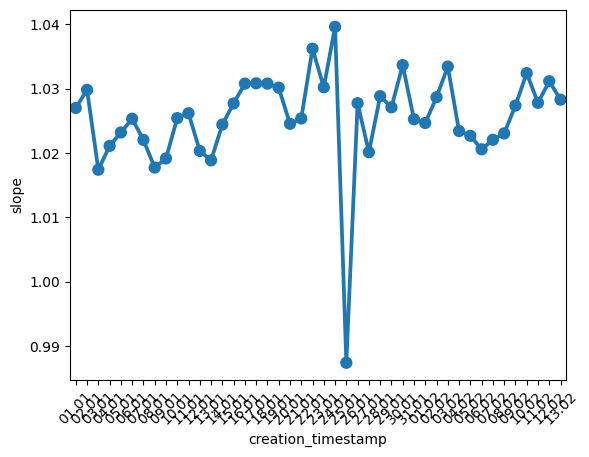

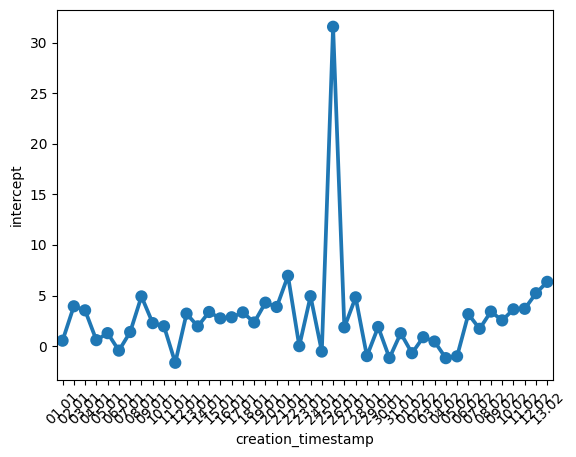

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.pointplot(data=dfg_test.collect().to_pandas(), x="creation_timestamp", y="slope")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
plt.show()

sns.pointplot(data=dfg_test.collect().to_pandas(), x="creation_timestamp", y="intercept")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
plt.show()
